## Testing

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from nerfstudio.cameras.cameras import Cameras, CAMERA_MODEL_TO_TYPE
from image_restoration_src.corruption.ocean import *
from image_restoration_src.common import ASSETS_DIR
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import random

In [3]:
def generate_ocean_patch(Lx: float, Lz: float, M: int, N: int, wind: Float[Tensor,"2"], t: float = 0, **kwargs) -> OceanPatch:
    """ Generate a random ocean patch at a given timestamp using FFT method described in:

    https://people.computing.clemson.edu/~jtessen/reports/papers_files/coursenotes2004.pdf (Section 4.3 and 4.4)

    The wave height of an Lx x Lz ocean patch at M x N resolution is given the 2D Discrete Fourier Transform

        h(x, t) = sum_k( h_k(t) * exp(i * k * x) )

    where k is the wave number vector, determined by the ocean patch size and grid resolution. 
    The slope vector is given by the gradient of the wave height

        e(x, t) = grad(h(x, t))
                = sum_k( i * k * h_k(t) * exp(i * k * x) )
    
    And the normal vector is given by
                
        n(x, t) = y_hat - e(x, t) / sqrt(1 + |e(x, t)|^2)

    Statisitcal analysis of waves have shown the fourier amplitudes h(k, t) can be modeled by gaussian random variables
    according to the wave spectrum P_h(k) and dispersion relation omega(k)

        h_(k, 0) = (N(0, 1) + i * N(0, 1)) * sqrt(P_h(k) / 2)
    
    and at time t

        h_(k, t) = h_(k, 0) * exp(i * omega(k) * t)
    
    Note the paper adds an additional term to preserve Hermitian symmetry in the fourier amplitudes

        + conj(h_(k, 0)) * exp(-i * omega(k) * t)

    but for our implementation, we can just use the irfft2 function.
        
    Params:
        Lx: Size of the ocean patch in x direction (m)
        Lz: Size of the ocean patch in y direction (m)
        M: Resolution of the ocean patch in x direction
        N: Resolution of the ocean patch in y direction
        t: Timestamp to simulate
        wind: Vector representing the wind direction and speed (m/s)

    Returns:
        Ocean patch with height and normal maps as well as position map for each grid point
    """
    # Generate wave numbers
    dx = 2 * torch.pi / Lx
    dy = 2 * torch.pi / Lz
    kx = torch.fft.fftfreq (M, d=dx) # Wave numbers in x (0, 1, ..., N/2, -N/2, ..., -1)
    kz = torch.fft.rfftfreq(N, d=dy) # Wave numbers in y (0, 1, ..., N/2)
    kx, kz = torch.meshgrid(kx, kz, indexing='xy')
    k = torch.sqrt(kx ** 2 + kz ** 2)

    # Compute Phillips spectrum
    P_h = generate_ocean_patch_wave_spectrum(k, kx, kz, wind, **kwargs)
    
    # Dispersion relation
    omega = generate_ocean_patch_dispersion_relation(k)
    
    # Fourier amplitudes at time 0 ~ gaussian random variables
    xi_real = torch.randn(N//2 + 1, M)
    xi_imag = torch.randn(N//2 + 1, M)
    h_k0 = (xi_real + 1j * xi_imag) * torch.sqrt(P_h) # real DC and Nyquist frequencies handled by irfft2

    # Fourier amplitudes at time t
    h_kt = h_k0 * torch.exp(1j * omega * t) #+ torch.conj(-h_k0) * torch.exp(-1j * omega * t)

    # Compute height, tangent, and normal maps
    hmap = torch.fft.irfft2(h_kt, s=(N, M))
    hmap_grad_x = torch.fft.irfft2(1j * kx * h_kt, s=(N, M)) * M / Lx # rescale to match grid resolution
    hmap_grad_z = torch.fft.irfft2(1j * kz * h_kt, s=(N, M)) * N / Lz
    hmap_grad = torch.stack([hmap_grad_x, hmap_grad_z], dim=-1)
    nmap = torch.stack([-hmap_grad_x, torch.ones_like(hmap), -hmap_grad_z], dim=-1)
    nmap = torch.nn.functional.normalize(nmap, p=2, dim=-1)

    # Compute positions at each grid point
    x = torch.linspace(0, Lx, M)
    z = torch.linspace(0, Lz, N)
    x, z = torch.meshgrid(x, z, indexing='ij')
    rmap = torch.stack([x, hmap, z], dim=-1)

    return OceanPatch(hmap, nmap, rmap, dict(Lx=Lx, Lz=Lz, M=M, N=N, t=t, wind=wind, height_grad=hmap_grad))

In [4]:
def apply_corruption_ocean(
    patch: OceanPatch,
    image: Float[Tensor, "H W 3"],
    depth: Float[Tensor, "H W"] = None,
    light: Float[Tensor, "3"] = None,
    light_ambient: float = 0, 
    light_scatter: float = 0,
    light_specular_mult: float = 0.95,
    light_specular_gain: float = 0.1,
    device='cuda',
) -> Float[Tensor, "H W 3"]:
    """
    """
    H, W = image.shape[:2]
    M, N, Lx, Lz = patch.metadata['M'], patch.metadata['N'], patch.metadata['Lx'], patch.metadata['Lz']
    depth = depth if depth is not None else torch.full((H, W), 5)
    light = light if light is not None else -UP_DIRECTION
    color = generate_ocean_albedo(depth)
    image = image.to(device)
    depth = depth.to(device)
    light = light.to(device)
    color = color.to(device)

    image_bottom = generate_ocean_bottom_lightmap(
        patch, 
        image, 
        depth, 
        light, 
        light_ambient=light_ambient, 
        light_scatter=light_scatter, 
        device=device
    )

    # compute camera ray bundle
    bundle = patch.camera_bundle()

    # reflection and refraction are symmetric wrt time reversal
    ni = bundle.directions[..., 0, :]
    ns = patch.normal
    ni = ni.to(device)
    ns = ns.to(device)
    nr = reflection(ni, ns)
    nt = refraction(ni, ns, REFRACTION_INDEX['air'], REFRACTION_INDEX['water'])
    reflection_mult, transmission_mult = compute_fresnel(ni, ns, nt)

    accum = torch.zeros((H, W, 3), device=device)

    # trace (inverse) light rays from ocean surface to ocean bottom
    points = patch.points.to(device)
    distance = torch.abs((points[..., 1] + depth) / nt[..., 1]) # (H, W)
    bottom_points = points - distance[..., None] * nt  # (H, W, 3)

    # constant directional light so can accumulate off grid points
    x, z, _ = points2indices(bottom_points, M, N, Lx, Lz, mod=True)
    x = x.reshape(H, W)
    z = z.reshape(H, W)
    accum = compute_transmission(
        image_bottom,
        depth[..., None],
        light,
        light_ambient,
        light_scatter, 
        transmission_mult[..., None]
    )[x, z] * color
    #accum = torch.log(1 + accum) # smooth out lightmap

    # compute reflection by seeing if unreflected ray is within cosine threshold of vertical
    reflection_unit = torch.tensor([light[0], -light[1], light[2]], device=device) / torch.norm(light)
    reflection_mask = torch.sum(nr * reflection_unit, dim=-1) > light_specular_mult
    reflection_gain = torch.norm(light) * reflection_mult[..., None] * light_specular_gain
    #reflection_gain = reflection_gain * color
    accum = torch.where(reflection_mask[..., None], reflection_gain + accum, accum)

    return torch.clamp(accum, 0, 1)

In [10]:
# Paths
imagenet_dir = "imagenet-mini/train"  # Replace with ImageNet directory
output_dir = "imagenet_corrupted3"  # Replace with output directory

# Parameters
batch_size = 16
num_workers = 4

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Transform to preprocess ImageNet images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
])

# Load ImageNet dataset
dataset = datasets.ImageFolder(imagenet_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Process each batch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for idx, (images, _) in enumerate(dataloader):
    images = images.to(device)

    for i, image in enumerate(images):
        M = 256  # Resolution
        N = 256
        Lx = 64  # Patch size (m)
        Lz = 64
        wind = torch.tensor([20, 20], device=device).float()  # Wind vector (m/s)
        t = 0  # Time
        patch = generate_ocean_patch(Lx, Lz, M, N, wind, t, wind_alignment=6, wave_dampening=0.05).to(device)

        # Depth and lighting configuration
        depth = torch.full((M, N), 0.01, device=device)  # Depth map for caustics
        light = torch.tensor([0, -1.0, 0], device=device)
        light = light / torch.norm(light) * 2.0  # Normalize and scale light intensity
        light_ambient = 0.05
        light_scatter = 0.05
        light_specular_mult = 0.85
        light_specular_gain = 5.0

        # Apply corruption
        image_corrupted = apply_corruption_ocean(
            patch,
            image,
            depth,
            light,
            light_ambient=light_ambient,
            light_scatter=light_scatter,
            light_specular_mult=light_specular_mult,
            light_specular_gain=light_specular_gain,
            device=device,
        )

        # Ensure corrupted image is in the correct range and format
        image_corrupted = torch.clamp(image_corrupted, 0, 1)
        if image_corrupted.shape[-1] == 3:  # If channel is last
            image_corrupted = image_corrupted.permute(2, 0, 1)  # Convert to [C, H, W]

        # Save corrupted image
        output_path = os.path.join(output_dir, f"batch_{idx}_image_{i}.png")
        save_image(image_corrupted, output_path)

        break  # Remove this if you want to process the entire batch

    print(f"Processed batch {idx+1}/{len(dataloader)}")

print("Corruption process completed!")


cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
from PIL import Image

output_dir = "imagenet_corrupted"  # Replace with output directory

images = os.listdir("assets")

M = 2048 # resolution
N = 2048
Lx = 64 # patch size (m)
Lz = 64
wind = torch.tensor([20, 20]).float() # wind vector (m/s)
t = 0 # time
patch = generate_ocean_patch(Lx, Lz, M, N, wind, t=t, wind_alignment=6, wave_dampening=0.05)

def load_image(name: str):
    image = Image.open(ASSETS_DIR / name)
    image = image.resize((M, N))
    image = torch.tensor(np.array(image)) / 255.0
    return image

for path in images:
    im = load_image(path)

    #image = torch.ones((H, W, 3))
    depth = torch.full((M, N), 0.01) # 0.01 for caustics
    light = torch.tensor([0, -1.0, 0])
    light = light / torch.norm(light) * 2.0 # intensity
    light_ambient = 0.05
    light_scatter = 0.05
    light_specular_mult = 0.85
    light_specular_gain = 5.0
    device = 'cuda'

    image_corrupted = apply_corruption_ocean(
        patch, 
        im, 
        depth, 
        light, 
        light_ambient=light_ambient,
        light_scatter=light_scatter,
        light_specular_mult=light_specular_mult,
        light_specular_gain=light_specular_gain,
        device=device
    )

    output_path = os.path.join(output_dir, f"path.png")
    save_image(image_corrupted, output_path)
    

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [1]:
import os
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
import matplotlib.pyplot as plt
from src.image_restoration.corruption.transforms import ApplyOceanCorruption

# Initialize the transform
transform = ApplyOceanCorruption(Lx=64, Lz=64, size=(2048, 2048), device='cuda')

# Path to the assets folder
assets_folder = "assets"

# Process all images in the folder
for filename in os.listdir(assets_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid image files
        image_path = os.path.join(assets_folder, filename)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        
        # Resize the image to (256, 256)
        resize_transform = Resize((2048, 2048))
        image = resize_transform(image)
        
        # Convert the image to a tensor
        image_tensor = ToTensor()(image)
        
        # Apply the ocean corruption transform
        transformed_tensor = transform(image_tensor)
        
        # Convert the transformed tensor back to a PIL image
        transformed_image = ToPILImage()(transformed_tensor.cpu())
        
        # # Display the original and transformed images
        # fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        # axs[0].imshow(image)
        # axs[0].set_title("Original Image (Resized)")
        # axs[0].axis("off")
        
        # axs[1].imshow(transformed_image)
        # axs[1].set_title("Transformed Image")
        # axs[1].axis("off")
        
        # plt.show()


tensor([45.3362, 35.8668])
0
4.446955440770141
0.05
1.834726572342049
tensor([ 8.4755,  0.8004, -0.9213])
2.444884489846808
0.946061513534944
0.3355918120432304
0.65243146405133
3.2237406055710363


AssertionError: 

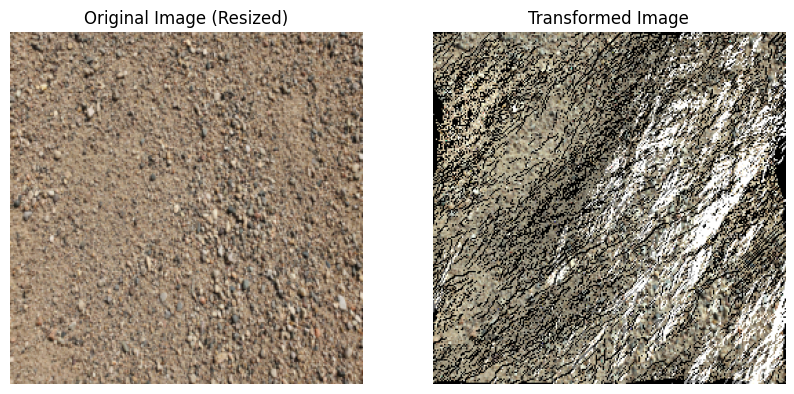

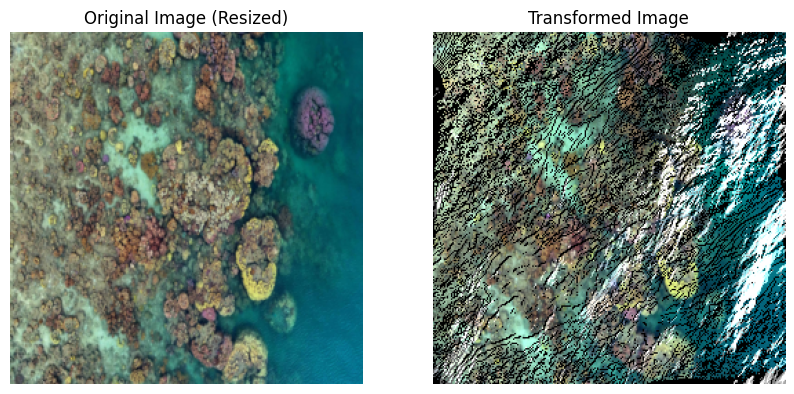

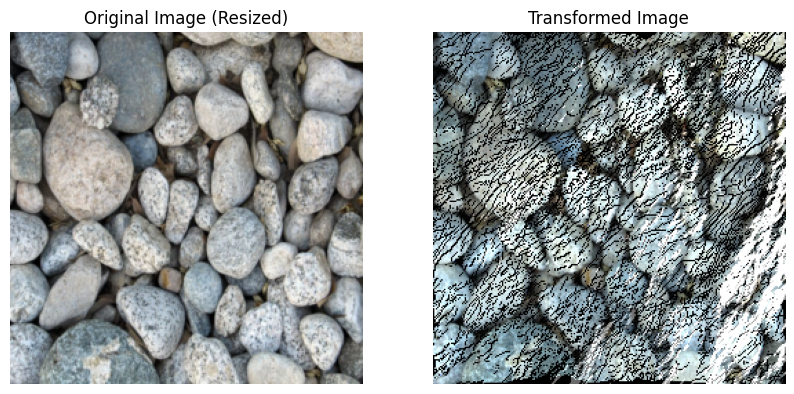

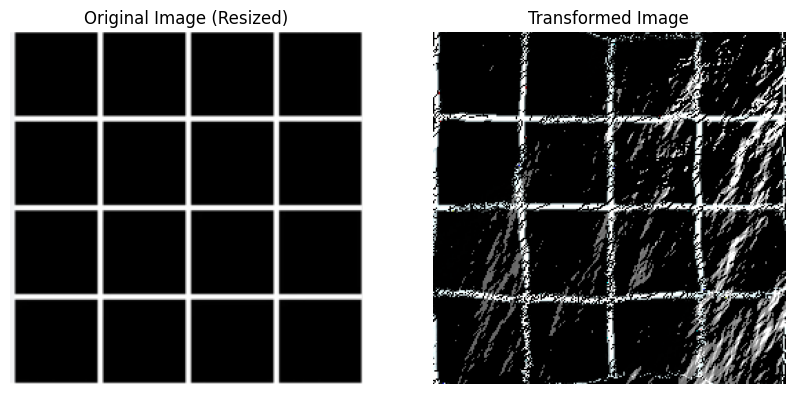

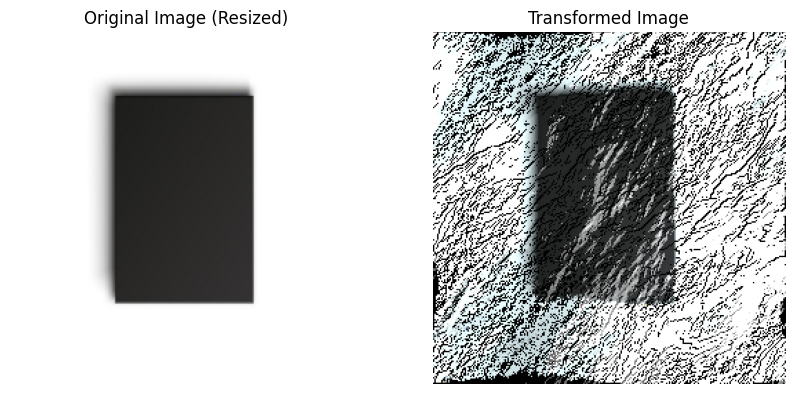

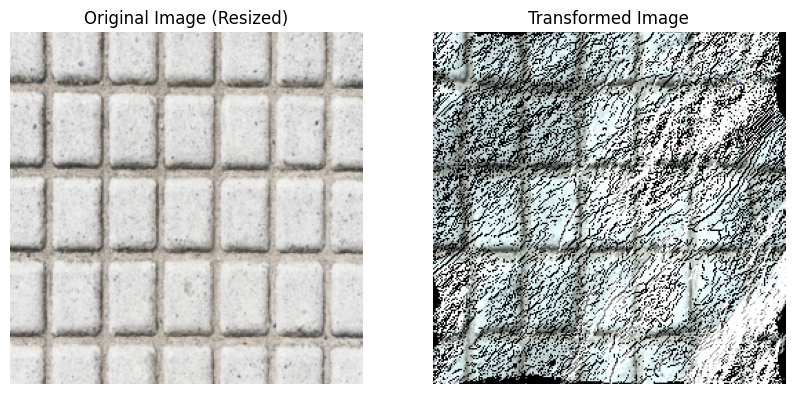

In [3]:
import os
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
import matplotlib.pyplot as plt
from src.image_restoration.corruption.transforms import ApplyOceanCorruption

# Initialize the transform
transform = ApplyOceanCorruption(Lx=64, Lz=64, size=(256, 256), device='cuda')

# Path to the assets folder
assets_folder = "assets"

# Process all images in the folder
for filename in os.listdir(assets_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid image files
        image_path = os.path.join(assets_folder, filename)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        
        # Resize the image to (256, 256)
        resize_transform = Resize((256, 256))
        image = resize_transform(image)
        
        # Convert the image to a tensor
        image_tensor = ToTensor()(image)
        
        # Apply the ocean corruption transform
        transformed_tensor = transform(image_tensor)
        
        # Convert the transformed tensor back to a PIL image
        transformed_image = ToPILImage()(transformed_tensor.cpu())
        
        # Display the original and transformed images
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Original Image (Resized)")
        axs[0].axis("off")
        
        axs[1].imshow(transformed_image)
        axs[1].set_title("Transformed Image")
        axs[1].axis("off")
        
        plt.show()


In [26]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor, Compose, Resize
from image_restoration_src.corruption.transforms import ApplyOceanCorruption

# Define the ApplyOceanCorruption transform
ocean_transform = ApplyOceanCorruption(Lx=64, Lz=64, size=(2048, 2048), device='cuda')

# Define preprocessing pipeline
transform_pipeline = Compose([
    Resize((256, 256)),  # Resize ImageNet images to (256, 256)
    ToTensor(),          # Convert images to tensors
    ocean_transform      # Apply the ocean corruption transform
])

# Load ImageNet dataset
imagenet_dataset = ImageNet(
    root="imagenet-mini",  # Update this to the location of your ImageNet dataset
    split="train",            # Use "train" or "val" split
    transform=transform_pipeline
)

# Create DataLoader
dataloader = DataLoader(
    imagenet_dataset,
    batch_size=32,      # Adjust batch size as needed
    shuffle=True,       # Shuffle data
    num_workers=4,      # Number of worker threads
    pin_memory=True     # Pin memory for faster data transfer to GPU
)

# Example: Iterating through the DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i, (images, labels) in enumerate(dataloader):
    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Visualize a batch of transformed images
    if i == 0:  # Display only the first batch
        import matplotlib.pyplot as plt
        grid_img = torch.cat([img for img in images.cpu()], dim=-1)
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Batch of Ocean-Corrupted Images")
        plt.show()
    break


RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in imagenet-mini.

## Generate Dataset

In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from src.image_restoration.corruption.transforms import ApplyOceanCorruption

# Define the ApplyOceanCorruption transform
ocean_transform = ApplyOceanCorruption(Lx=64, Lz=64, size=(256, 256), device='cuda')

# Define preprocessing pipeline
resize_transform = transforms.Resize((256, 256))
to_tensor_transform = transforms.ToTensor()

# Input and output directories
ground_truth_folder = "ground_truth"
distorted_folder = "distorted"

# Ensure output folder exists
os.makedirs(distorted_folder, exist_ok=True)

# Get all image paths from the ground truth folder
image_paths = [
    os.path.join(ground_truth_folder, filename)
    for filename in os.listdir(ground_truth_folder)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Process and save images
for image_path in image_paths:
    # Get the filename
    filename = os.path.basename(image_path)

    # Load and preprocess the ground truth image
    ground_truth_image = Image.open(image_path).convert("RGB")
    resized_image = resize_transform(ground_truth_image)
    ground_truth_tensor = to_tensor_transform(resized_image)

    # Apply the ocean corruption transform
    distorted_tensor = ocean_transform(ground_truth_tensor.to(device))

    # Convert tensors back to PIL images
    distorted_image = transforms.ToPILImage()(distorted_tensor.cpu())

    # Save the distorted image
    distorted_image.save(os.path.join(distorted_folder, filename))

print(f"Distorted images saved in '{distorted_folder}'.")


tensor([34.2685, 44.6576])
0
2.968728586516437
0.05
1.517522947948326
tensor([ 7.1457,  0.4173, -0.0424])
1.7628342251692353
0.4138921691298823
0.39864926083924757
0.9478601656907581
0.4235039301818144


AssertionError: 

## Train the UNet

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torchvision.models import vgg16

In [3]:
# Define U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder: Input is 3 channels (RGB)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Input channels = 3 (RGB image)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Reduces size to half (128x128 -> 64x64)
        )
        
        # Decoder: Upsample and output 3 channels (RGB)
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # Upsample the image
        )
        
        # Final convolution layer to ensure the output is 3 channels (RGB)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)  # Reduces channels to 3 for RGB output
    
    def forward(self, x):
        # Pass through the encoder (downsampling)
        x1 = self.encoder(x)
        
        # Pass through the decoder (upsampling)
        x2 = self.decoder(x1)
        
        # Final output (RGB image)
        x3 = self.final_conv(x2)  # Use final convolution to reduce to 3 channels (RGB)
        return x3



# Dataset Class
class PairedDataset(Dataset):
    def __init__(self, distorted_dir, ground_truth_dir, transform=None):
        self.distorted_images = sorted(os.listdir(distorted_dir))
        self.ground_truth_images = sorted(os.listdir(ground_truth_dir))
        self.distorted_dir = distorted_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform

    def __len__(self):
        return len(self.distorted_images)

    def __getitem__(self, idx):
        distorted_path = os.path.join(self.distorted_dir, self.distorted_images[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.ground_truth_images[idx])
        distorted = Image.open(distorted_path).convert("RGB")
        ground_truth = Image.open(ground_truth_path).convert("RGB")
        if self.transform:
            distorted = self.transform(distorted)
            ground_truth = self.transform(ground_truth)
        return distorted, ground_truth
    
# Data preparation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])




In [ ]:
dataset = PairedDataset("distorted", "ground_truth", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Loss and optimizer
model = UNet().to('cuda')
criterion = nn.L1Loss()  # Use L1Loss or MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):
    for distorted, ground_truth in dataloader:
        distorted, ground_truth = distorted.to('cuda'), ground_truth.to('cuda')
        optimizer.zero_grad()
        output = model(distorted)
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/10], Loss: {loss.item():.4f}")

In [ ]:
# Save the model weights after training
model_save_path = "unet_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")



In [7]:

# Inference with the saved model
def load_model(model_path):
    model = UNet().to('cuda')
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model


def infer(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to('cuda'))  # Add batch dimension
        return output.squeeze(0).cpu()  # Remove batch dimension

# Load model weights for inference
model = load_model("unet_model.pth")

# Example of running inference
test_image = Image.open("corrupted_images/pebbles_depth_0.1m.jpg").convert("RGB")
test_image_tensor = transform(test_image).to('cuda')

output_image_tensor = infer(model, test_image_tensor)

# Convert the output tensor to a PIL image and save
output_image = transforms.ToPILImage()(output_image_tensor)
output_image.save("output_image.jpg")
print("Inference result saved as output_image.jpg")

/tmp/ipykernel_469333/2725584845.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Inference result saved as output_image.jpg


In [13]:
import os
import json

# Directories
ground_truth_dir = "ground_truth"
distorted_dir = "distorted"
output_file = "prompt.txt"

# Ensure both directories exist
if not os.path.exists(ground_truth_dir) or not os.path.exists(distorted_dir):
    raise ValueError("Both 'ground_truth' and 'distorted' directories must exist.")

# Get list of filenames
ground_truth_files = sorted(os.listdir(ground_truth_dir))
distorted_files = sorted(os.listdir(distorted_dir))

# Ensure files match in both directories
if ground_truth_files != distorted_files:
    raise ValueError("Filenames in 'ground_truth' and 'distorted' directories do not match.")

# Prepare the prompts
rows = []
for filename in ground_truth_files:
    row = {
        "source": f"{ground_truth_dir}/{filename}",
        "target": f"{distorted_dir}/{filename}",
        "prompt": "remove water and waves"
    }
    rows.append(row)

# Write to output file
with open(output_file, "w") as f:
    for row in rows:
        f.write(json.dumps(row) + "\n")

print(f"Prompt file '{output_file}' created successfully!")

Prompt file 'prompt.txt' created successfully!


In [17]:
import json
import cv2
import numpy as np

from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self):
        self.data = []
        with open('image_restoration_src/data/prompt.json', 'rt') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        source_filename = item['source']
        target_filename = item['target']
        prompt = item['prompt']

        source = cv2.imread(source_filename)
        target = cv2.imread(target_filename)

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1].
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target = target.astype(np.float32) / 255.0

        return dict(jpg=target, txt=prompt, hint=source)


In [19]:
dataset = MyDataset()
print(len(dataset))

item = dataset[1234]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)


50000
remove water and waves
(256, 256, 3)
(256, 256, 3)


## Run Inference

In [5]:

# Inference with the saved model
def load_model(model_path):
    model = UNet().to('cuda')
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model


def infer(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to('cuda'))  # Add batch dimension
        return output.squeeze(0).cpu()  # Remove batch dimension

# Load model weights for inference
model = load_model("unet_model_1300.pth")

# Example of running inference
test_image = Image.open("ControlNet/test_imgs/true_test_imgs/frame_014060.jpg").convert("RGB")
test_image_tensor = transform(test_image).to('cuda')

output_image_tensor = infer(model, test_image_tensor)

# Convert the output tensor to a PIL image and save
output_image = transforms.ToPILImage()(output_image_tensor)
output_image.save("output_image.jpg")
print("Inference result saved as output_image.jpg")

/tmp/ipykernel_3151980/4261375212.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Inference result saved as output_image.jpg


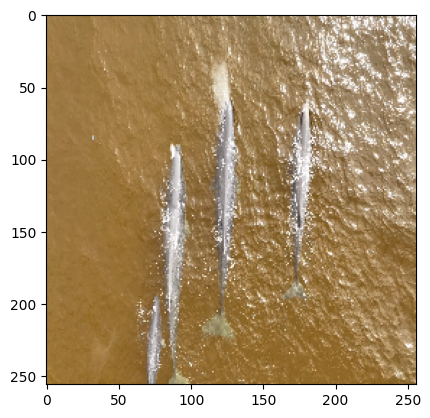

In [2]:
from PIL as 
import matplotlib.pyplot as plt

img = cv2.imread("ControlNet/test_imgs/true_test_imgs/frame_014060.jpg")

img = cv2.resize(img, (256, 256))
plt.imshow(img)
